In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
date = session.query(func.max(Measurement.date)).scalar()
date

'2017-08-23'

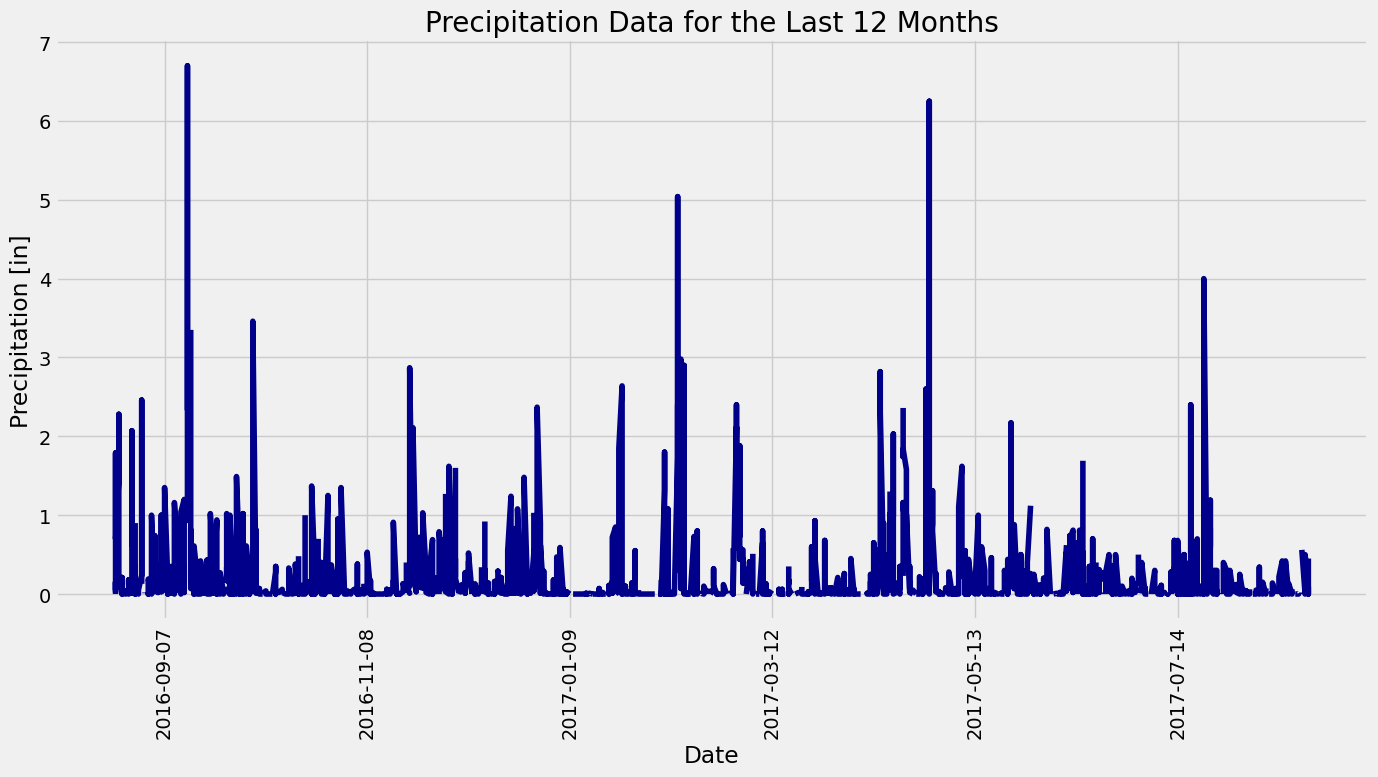

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= one_year_ago
).order_by(Measurement.date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(query.statement, engine)
df.columns = ['Date', 'Precipitation']

# Sort the dataframe by date
df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(14, 8))
plt.plot(df['Date'], df['Precipitation'], color='darkblue')
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation [in]')
plt.grid(True)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=62)) 
plt.tight_layout()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['Precipitation'].describe() 

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(Station.station)).scalar()
print(f'The total number of stations: {stations}')

The total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = (
    session.query(Station.station, func.count(Measurement.station).label('count'))
    .filter(Station.station == Measurement.station)
    .group_by(Station.station)
    .order_by(func.count(Measurement.station).desc()).all()
)

results = active_stations_query

print("Most Active Stations (Station, Count):")
for station, count in results:
    print(f'{station}: {count}')

Most Active Stations (Station, Count):
USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [14]:
# Using the most active station id from the previous query "USC00519281" calculate the lowest, highest, and average temperature.
temperature_stats_query = (
    session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    )
    .filter(Measurement.station == 'USC00519281')
)

# Execute the query and fetch the results
stats = temperature_stats_query.one()

# Print the results
print(f"Station ID: USC00519281")
print(f"Lowest Temperature: {stats.min_temp:.2f}")
print(f"Highest Temperature: {stats.max_temp:.2f}")
print(f"Average Temperature: {stats.avg_temp:.2f}")


Station ID: USC00519281
Lowest Temperature: 54.00
Highest Temperature: 85.00
Average Temperature: 71.66


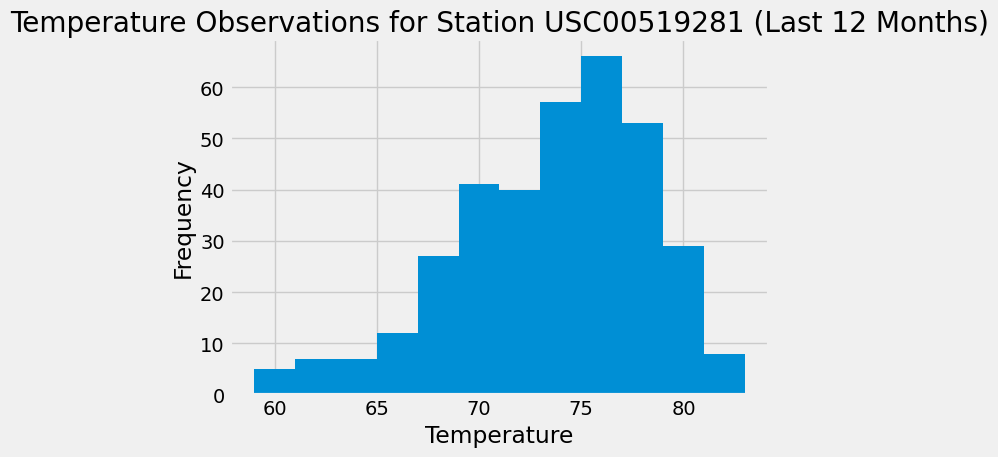

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

year = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').all()
temperatures = [temperatures[0] for temperatures in year]

plt.hist(temperatures, bins=12)
plt.title(f'Temperature Observations for Station USC00519281 (Last 12 Months)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()